# Task 2

In [16]:
# packages
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import try_all_threshold

## Process of forming final answer

I will first explain superficially the logic behind forming the function to fill this task.

#### importing the images

First we load the image from the database.

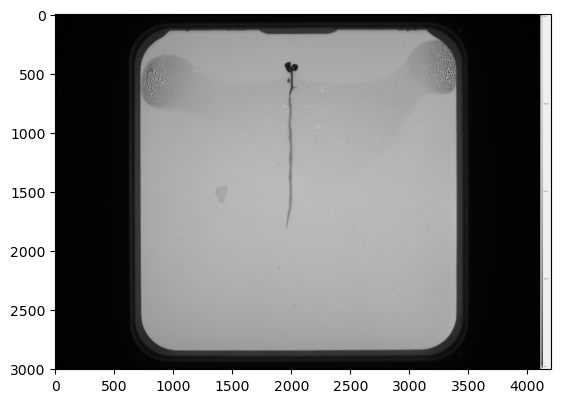

In [17]:
# IMAGE TO BE USED FOR TESTING
image_path = r"val_Myrthe_236578_im1.png"
im = cv2.imread(image_path, 0)
plt.imshow(im, cmap='gray')

### cropping the images

For this task I first tested some thresholding methods to make sure the objects are delimited properly.

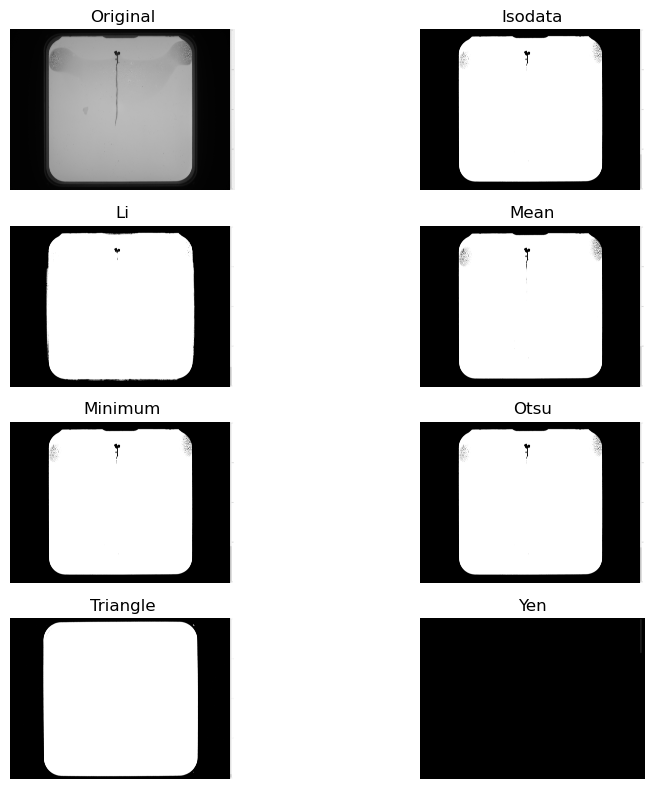

In [18]:
# FIGURE WHICH THRESHOLDING METHOD TO USE
fig, ax = try_all_threshold(im, figsize=(10, 8), verbose=False)

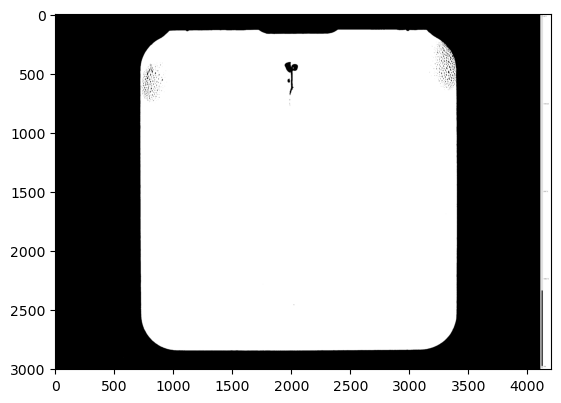

In [19]:
# TRY THE BINARY AND OTSU
th, output_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(output_im, cmap='gray')

In [20]:
th

92.0

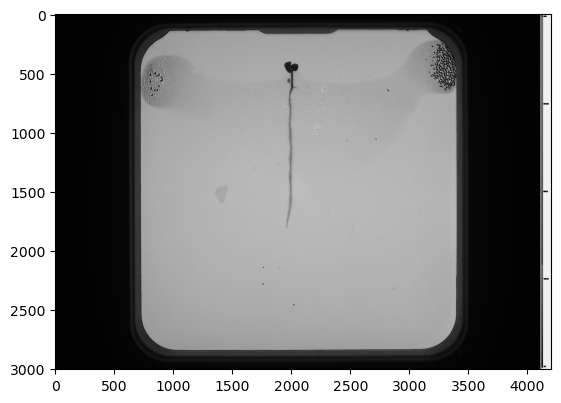

In [21]:
# DETECT THE CONTOUR
edges=cv2.Canny(im, threshold1= 91, threshold2=255)
contours, hierarchy = cv2.findContours(edges, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
im = cv2.drawContours(im, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

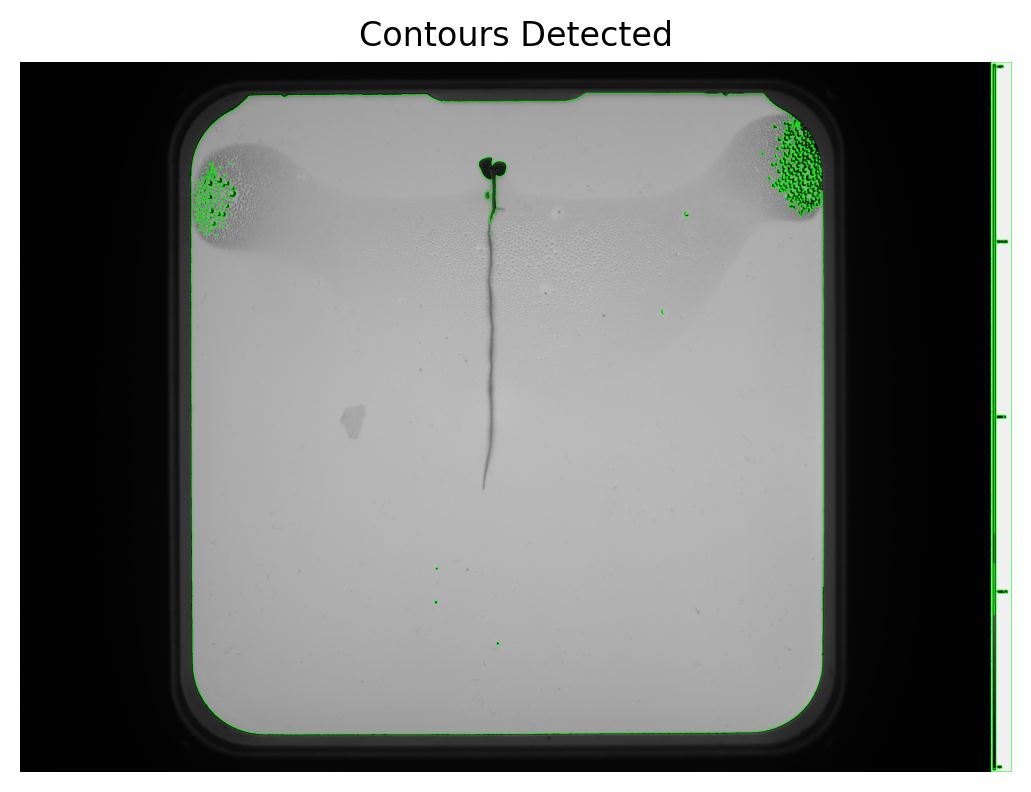

In [22]:
# DETECT THE CONTOUR
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

im_contours = im.copy()  # Copy of original image to draw contours
cv2.drawContours(im_contours, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)

im_rgb = cv2.cvtColor(im_contours, cv2.COLOR_BGR2RGB)

plt.figure(dpi=200)
plt.imshow(im_rgb)
plt.title("Contours Detected")
plt.axis("off")
plt.show()


I will use the CHAIN_APPROX_SIMPLE contour approximation method because it will extract the endpoints of the rectangle, and the RETR_EXTERNAL retrieval model to retrieve only the extreme outer contour.

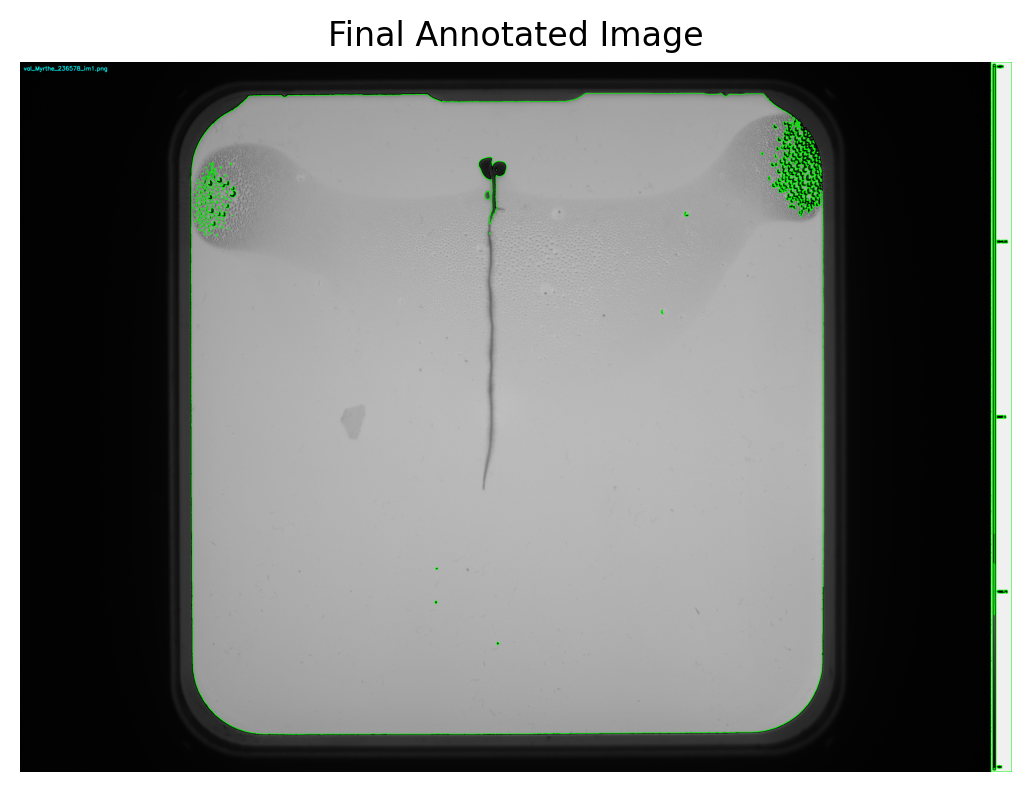

In [24]:
import os
# Annotate the image with contours and filename
# Get the filename to use as a label
filename = os.path.basename(image_path)

# Put text on the image
cv2.putText(im_rgb, filename, (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB))
plt.title("Final Annotated Image")
plt.axis("off")
plt.show()

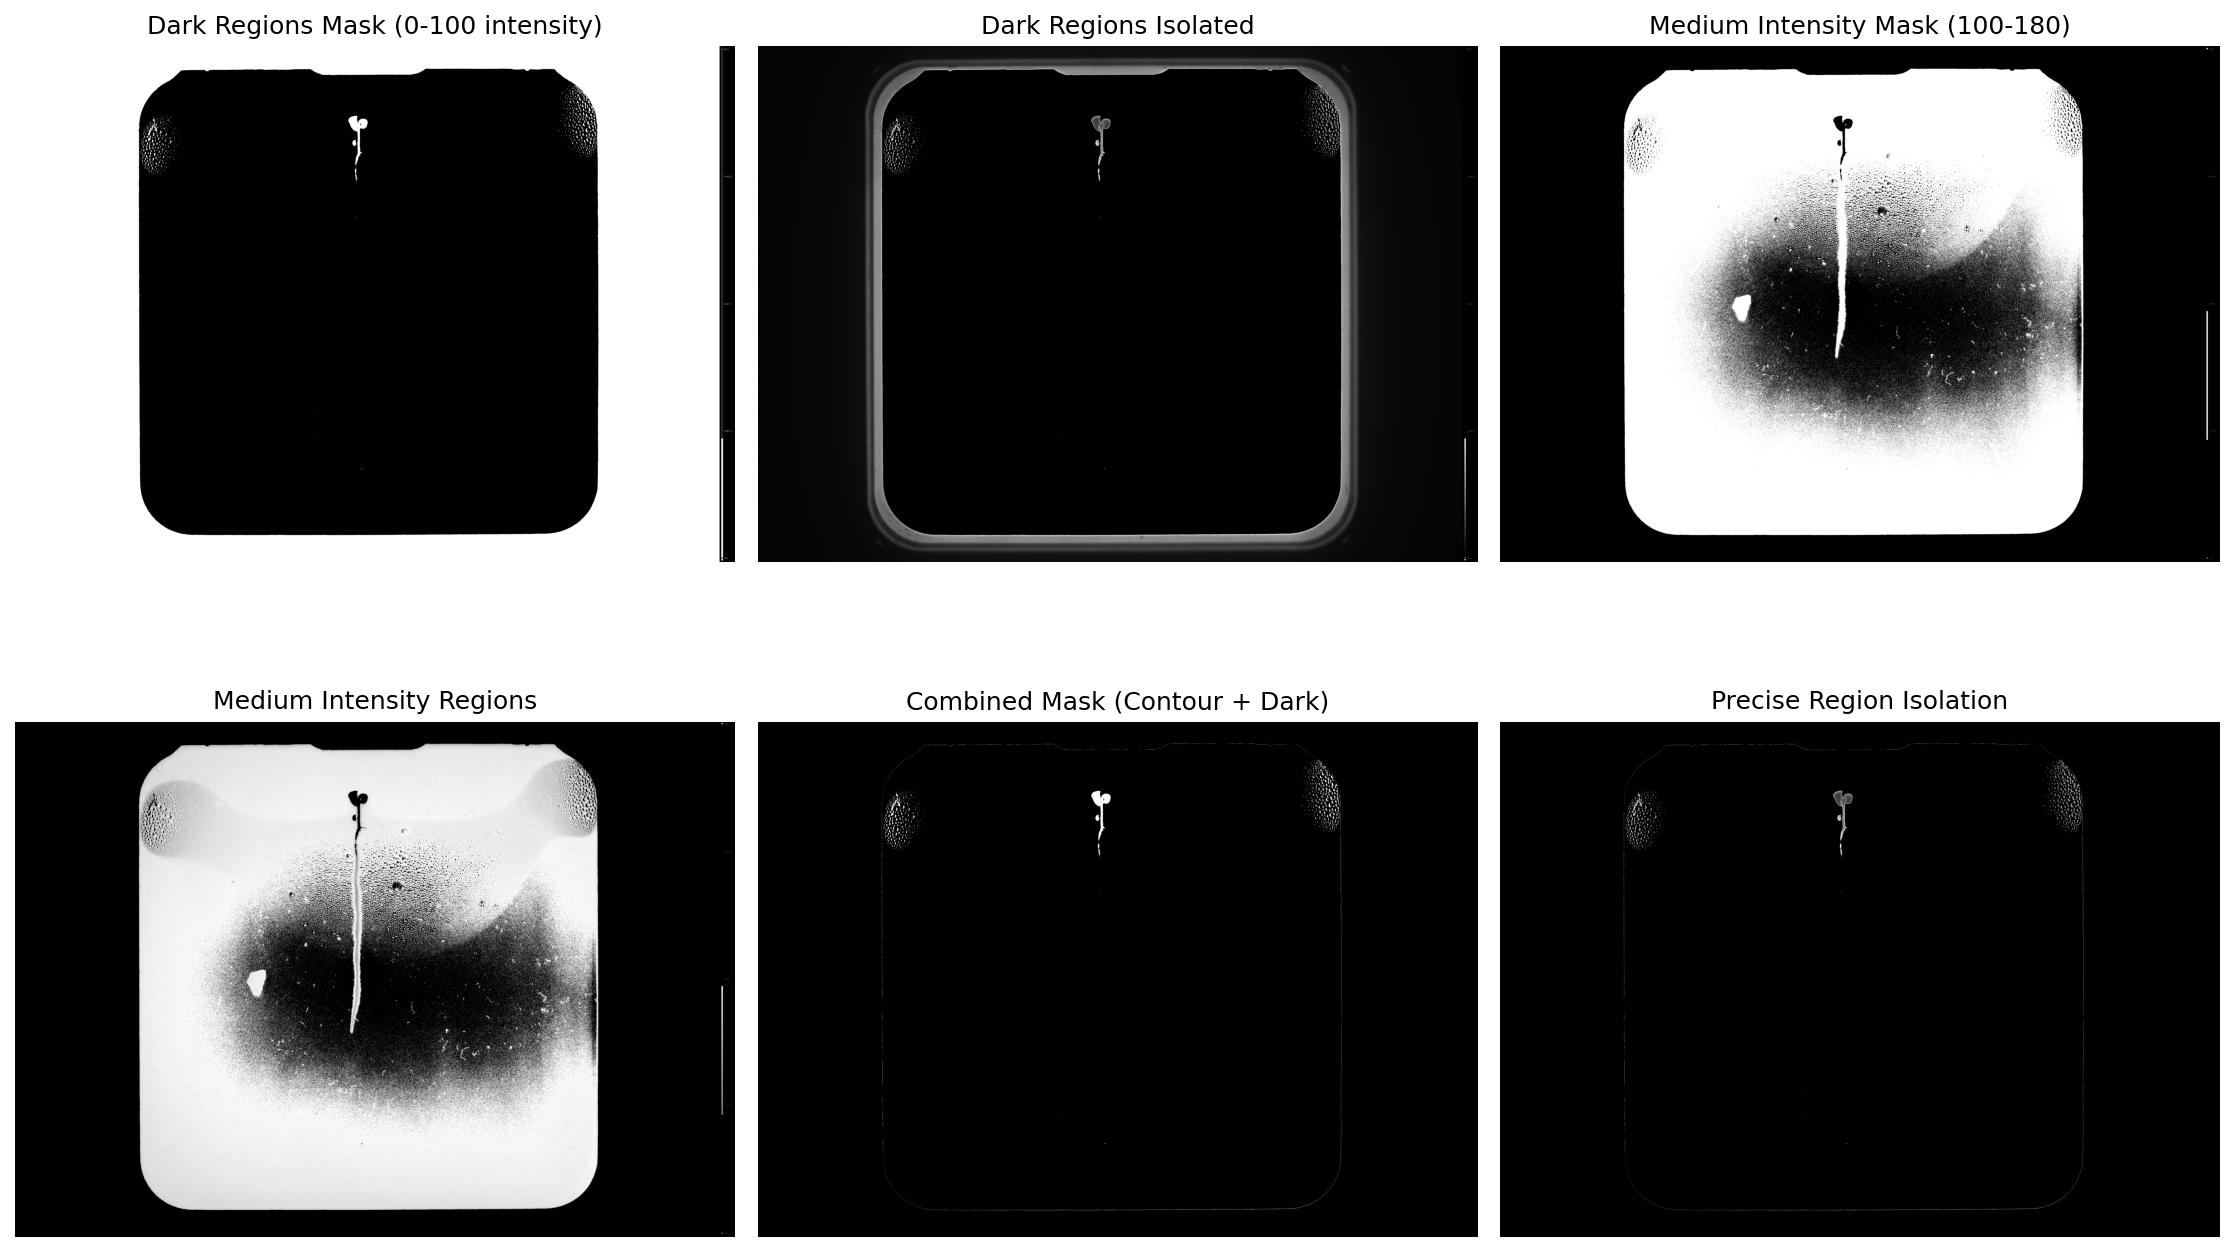

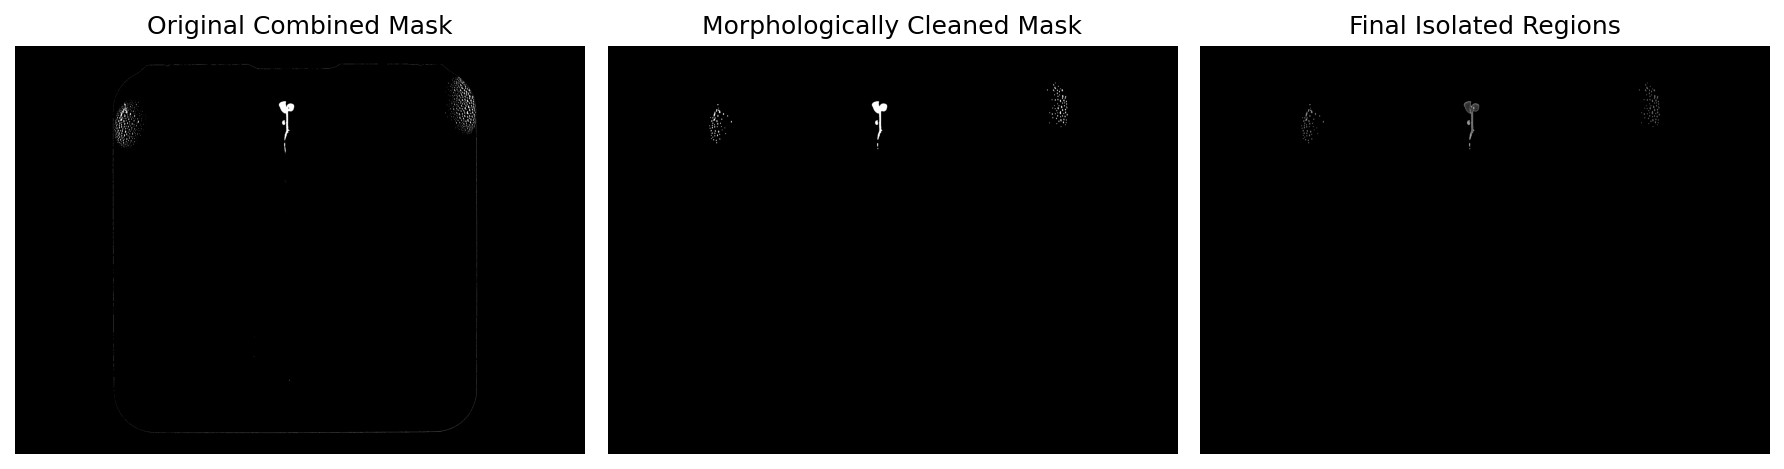

Mask Statistics:
Original image shape: (3006, 4202)
Dark regions mask area: 5263318 pixels
Medium intensity mask area: 5466785 pixels
Combined mask area: 36280 pixels
Cleaned mask area: 16961 pixels


In [28]:
# ADVANCED MASKING: ISOLATE SPECIFIC REGIONS OF INTEREST

# First, reload the original image to ensure we have the correct base image
original_im = cv2.imread(image_path, 0)

# Recreate the contour mask from the largest contour using the original image dimensions
contour_mask = np.zeros_like(original_im)
cv2.fillPoly(contour_mask, [largest_contour], 255)

# Create masks for different intensity ranges and regions
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)
axes = axes.flatten()

# 1. Intensity-based mask (isolate dark regions - potentially root areas)
dark_mask = cv2.inRange(original_im, 0, 100)  # Pixels with intensity 0-100
masked_dark = cv2.bitwise_and(original_im, original_im, mask=dark_mask)
axes[0].imshow(dark_mask, cmap='gray')
axes[0].set_title('Dark Regions Mask (0-100 intensity)')
axes[0].axis('off')

# 2. Apply dark mask
axes[1].imshow(masked_dark, cmap='gray')
axes[1].set_title('Dark Regions Isolated')
axes[1].axis('off')

# 3. Medium intensity mask (middle range)
medium_mask = cv2.inRange(original_im, 100, 180)  # Pixels with intensity 100-180
masked_medium = cv2.bitwise_and(original_im, original_im, mask=medium_mask)
axes[2].imshow(medium_mask, cmap='gray')
axes[2].set_title('Medium Intensity Mask (100-180)')
axes[2].axis('off')

# 4. Apply medium mask
axes[3].imshow(masked_medium, cmap='gray')
axes[3].set_title('Medium Intensity Regions')
axes[3].axis('off')

# 5. Combine contour mask with intensity mask for precise region isolation
combined_mask = cv2.bitwise_and(contour_mask, dark_mask)
masked_combined = cv2.bitwise_and(original_im, original_im, mask=combined_mask)
axes[4].imshow(combined_mask, cmap='gray')
axes[4].set_title('Combined Mask (Contour + Dark)')
axes[4].axis('off')

# 6. Apply combined mask
axes[5].imshow(masked_combined, cmap='gray')
axes[5].set_title('Precise Region Isolation')
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Create a morphological mask to remove noise
kernel = np.ones((5,5), np.uint8)
cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

# Display the cleaned mask
plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(1, 3, 1)
plt.imshow(combined_mask, cmap='gray')
plt.title('Original Combined Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Morphologically Cleaned Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
final_masked = cv2.bitwise_and(original_im, original_im, mask=cleaned_mask)
plt.imshow(final_masked, cmap='gray')
plt.title('Final Isolated Regions')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Mask Statistics:")
print(f"Original image shape: {original_im.shape}")
print(f"Dark regions mask area: {np.sum(dark_mask > 0)} pixels")
print(f"Medium intensity mask area: {np.sum(medium_mask > 0)} pixels")
print(f"Combined mask area: {np.sum(combined_mask > 0)} pixels")
print(f"Cleaned mask area: {np.sum(cleaned_mask > 0)} pixels")

## Final function

First, we read the image and convert it to grayscale from BGR. We apply Gaussian Blur with a kernel of 5 x 5 to reduce noise. Next, thresholding is used to detect the edges of the Petri dish using simple and Otsu thresholding. Then, we find the external contour and select the largest one (assuming it is the pietri dish). To be sure that the crop is square and centered we choose the maximum width and height from the created rectangle and finding the coordonates of the centre by  halfing the width and height. Subtracting half the square size from the center coordinates gives the top-left corner of the square, setting it to 0 if the value is negative. Then the image is cropped starting at (x_start, y_start) and extending to the same coordinates, but with the added size of the square itself.

In [ ]:
def crop_image (image):
    # read the image in grayscale
    im = cv2.imread(image, 0)

    # apply Gaussian Blur
    blur = cv2.GaussianBlur(im, (5,5), 0)

    # threshold the image to detect the edges of the Petri dish
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # select the largest contour (assume that is the pietri dish)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]

    # get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # ensure the bounding box is square
    square_size = max(w, h)

    # ensure the bounding box is centered
    x_center = x + w // 2
    y_center = y + h // 2

    x_start = max(x_center - square_size // 2, 0)
    y_start = max(y_center - square_size // 2, 0)

    # crop the image
    cropped_image = im[y_start:y_start+square_size, x_start:x_start+square_size]

    return cropped_image

## Testing the function

### 2023 dataset

Text(0.5, 1.0, 'Original image, 4202x3006')

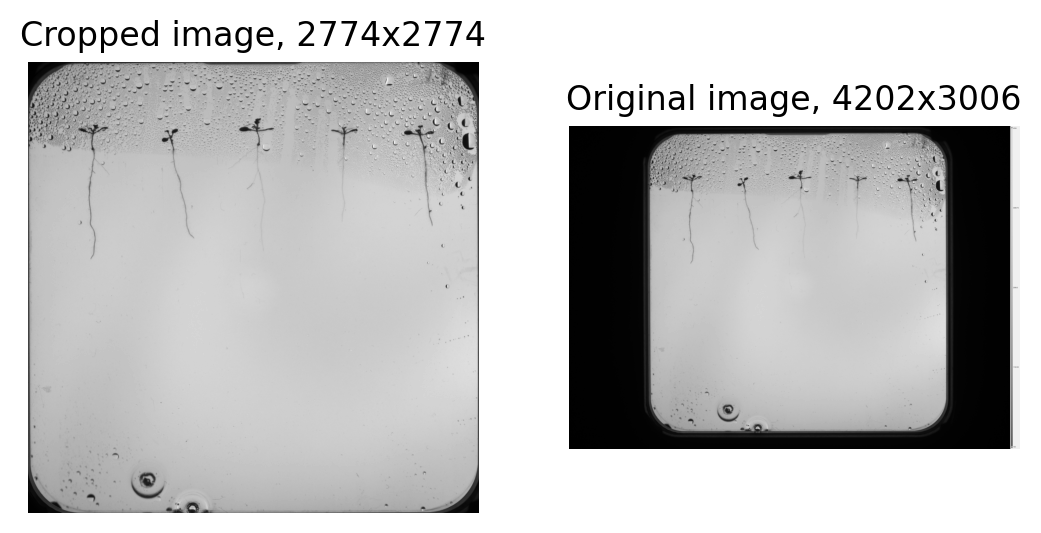

In [ ]:
# Image 1
fig, ax = plt.subplots(1, 2, dpi=200)
crop_im = crop_image("034_43-13-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_02-Fish Eye Corrected.png")
im = cv2.imread("034_43-13-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_02-Fish Eye Corrected.png", 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Size of the images (height, width)
crop_im_size = crop_im.shape[:2] 
im_size = im.shape[:2] 

ax[0].imshow(crop_im, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Cropped image, {crop_im_size[1]}x{crop_im_size[0]}')
ax[1].imshow(im, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Original image, {im_size[1]}x{im_size[0]}')

Text(0.5, 1.0, 'Original image, 4202x3006')

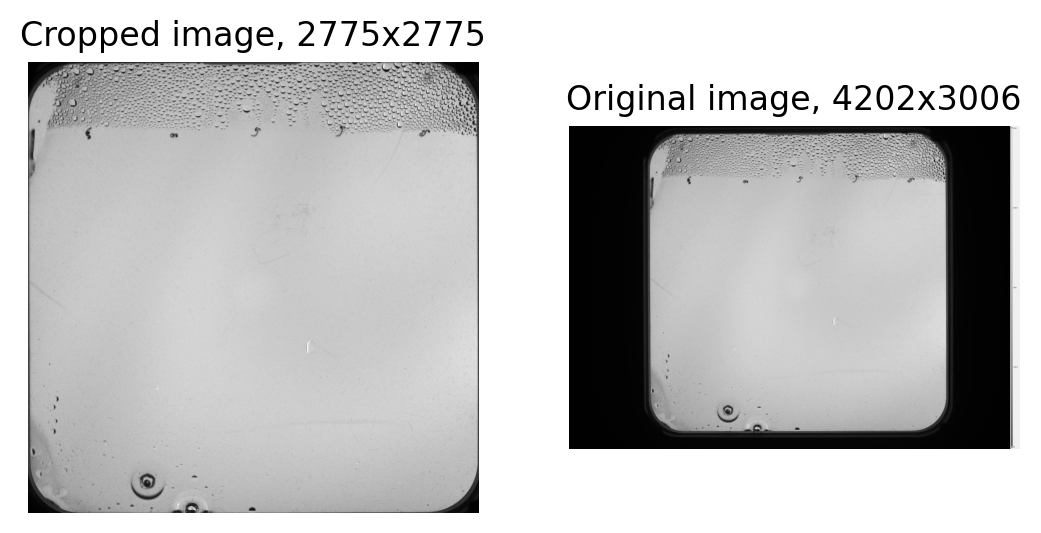

In [ ]:
# Image 2
fig, ax = plt.subplots(1, 2, dpi=200)
crop_im = crop_image("004_43-11-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected.png")
im = cv2.imread("004_43-11-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected.png", 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Size of the images (height, width)
crop_im_size = crop_im.shape[:2] 
im_size = im.shape[:2] 

ax[0].imshow(crop_im, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Cropped image, {crop_im_size[1]}x{crop_im_size[0]}')
ax[1].imshow(im, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Original image, {im_size[1]}x{im_size[0]}')

### 2024 dataset

Text(0.5, 1.0, 'Original image, 4202x3006')

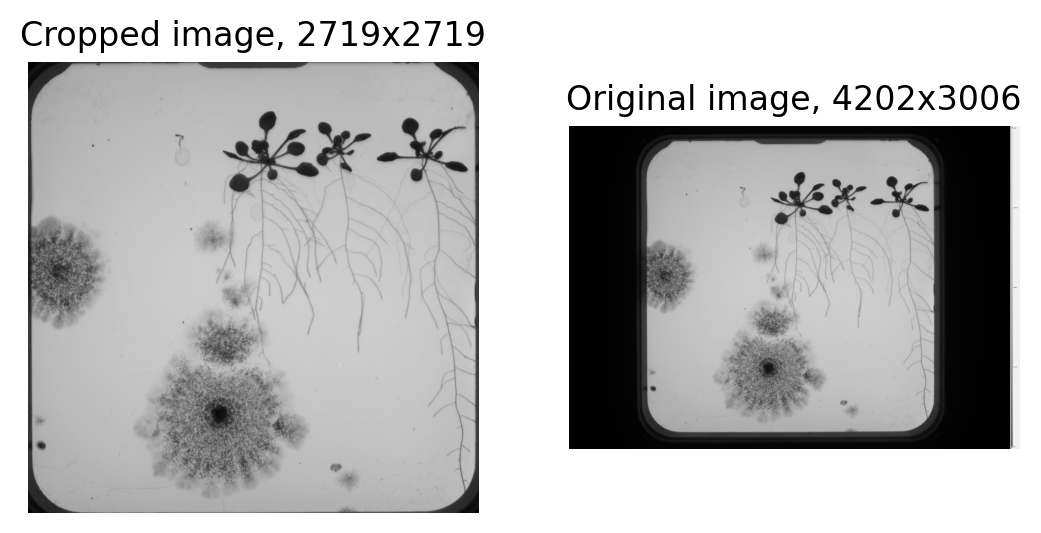

In [ ]:
# Image 1
fig, ax = plt.subplots(1, 2, dpi=200)
crop_im = crop_image("train_Alican_230858_im5.png")
im = cv2.imread("train_Alican_230858_im5.png", 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Size of the images (height, width)
crop_im_size = crop_im.shape[:2] 
im_size = im.shape[:2] 

ax[0].imshow(crop_im, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Cropped image, {crop_im_size[1]}x{crop_im_size[0]}')
ax[1].imshow(im, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Original image, {im_size[1]}x{im_size[0]}')

Text(0.5, 1.0, 'Original image, 4202x3006')

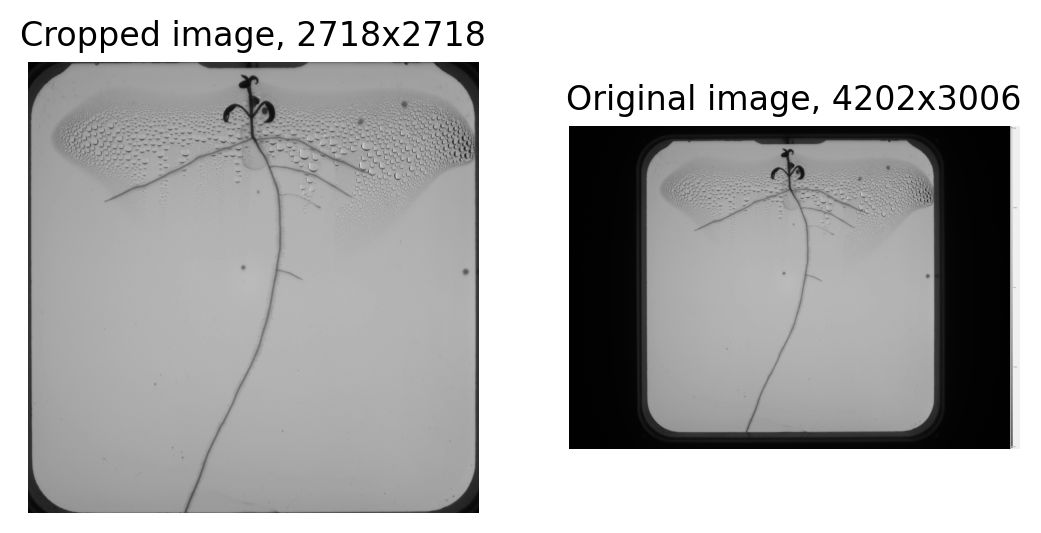

In [ ]:
# Image 1
fig, ax = plt.subplots(1, 2, dpi=200)
crop_im = crop_image("train_Karna_232753_im1.png")
im = cv2.imread("train_Karna_232753_im1.png", 0)
im = cv2.cvtColor(im, cv2.COLOR_BAYER_BG2GRAY)

# Size of the images (height, width)
crop_im_size = crop_im.shape[:2] 
im_size = im.shape[:2] 

ax[0].imshow(crop_im, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Cropped image, {crop_im_size[1]}x{crop_im_size[0]}')
ax[1].imshow(im, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Original image, {im_size[1]}x{im_size[0]}')